In [320]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import pickle
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance


In [321]:
# Load the dataset from the CSV file
wine_data = pd.read_csv("../../data/raw/winequality-red.csv", delimiter=',')


In [322]:
print("Dataset shape:", wine_data.shape)  # (rows, columns) Checks how many samples and features exist. 
display(wine_data.head())  # First 5 rows
print(wine_data.info())  # Data types & missing values
display(wine_data.describe())  # Provides statistical measures (mean, std, min, max, etc.).

Dataset shape: (1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


#  <span style="color: blue;"> Data Preprocessing <span>

## <span style="color: orange;"> Missing Values Check <span>

In [323]:
print("\nMissing values per column:")
print(wine_data.isnull().sum())


Missing values per column:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


Ensures there are no missing values before proceeding.

## <span style="color: orange;"> Outlier Detection & Capping <span>

### Outlier Detection (IQR Method)

Outliers can distort distance-based algorithms like KNN, so detecting and handling them is crucial.

The IQR method identifies outliers as points outside the range:

Lower bound = Q1 - 1.5 * IQR

Upper bound = Q3 + 1.5 * IQR

Here’s a function to detect outliers in any column:

In [324]:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower) | (df[column] > upper)]
    return outliers

### Outlier Capping (Clipping Extreme Values)

Instead of removing outliers, which can reduce data size, we can cap them to the nearest boundary values (lower or upper).

In [325]:
# Define outlier capping function
def cap_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[column] = np.clip(df[column], lower, upper)


In [326]:
# 3. Cap outliers on a copy of the data (excluding target 'quality')
wine_cleaned = wine_data.copy()
for col in wine_cleaned.columns[:-1]:  # exclude 'quality'
    cap_outliers_iqr(wine_cleaned, col)

## Boxplots After Outlier Capping

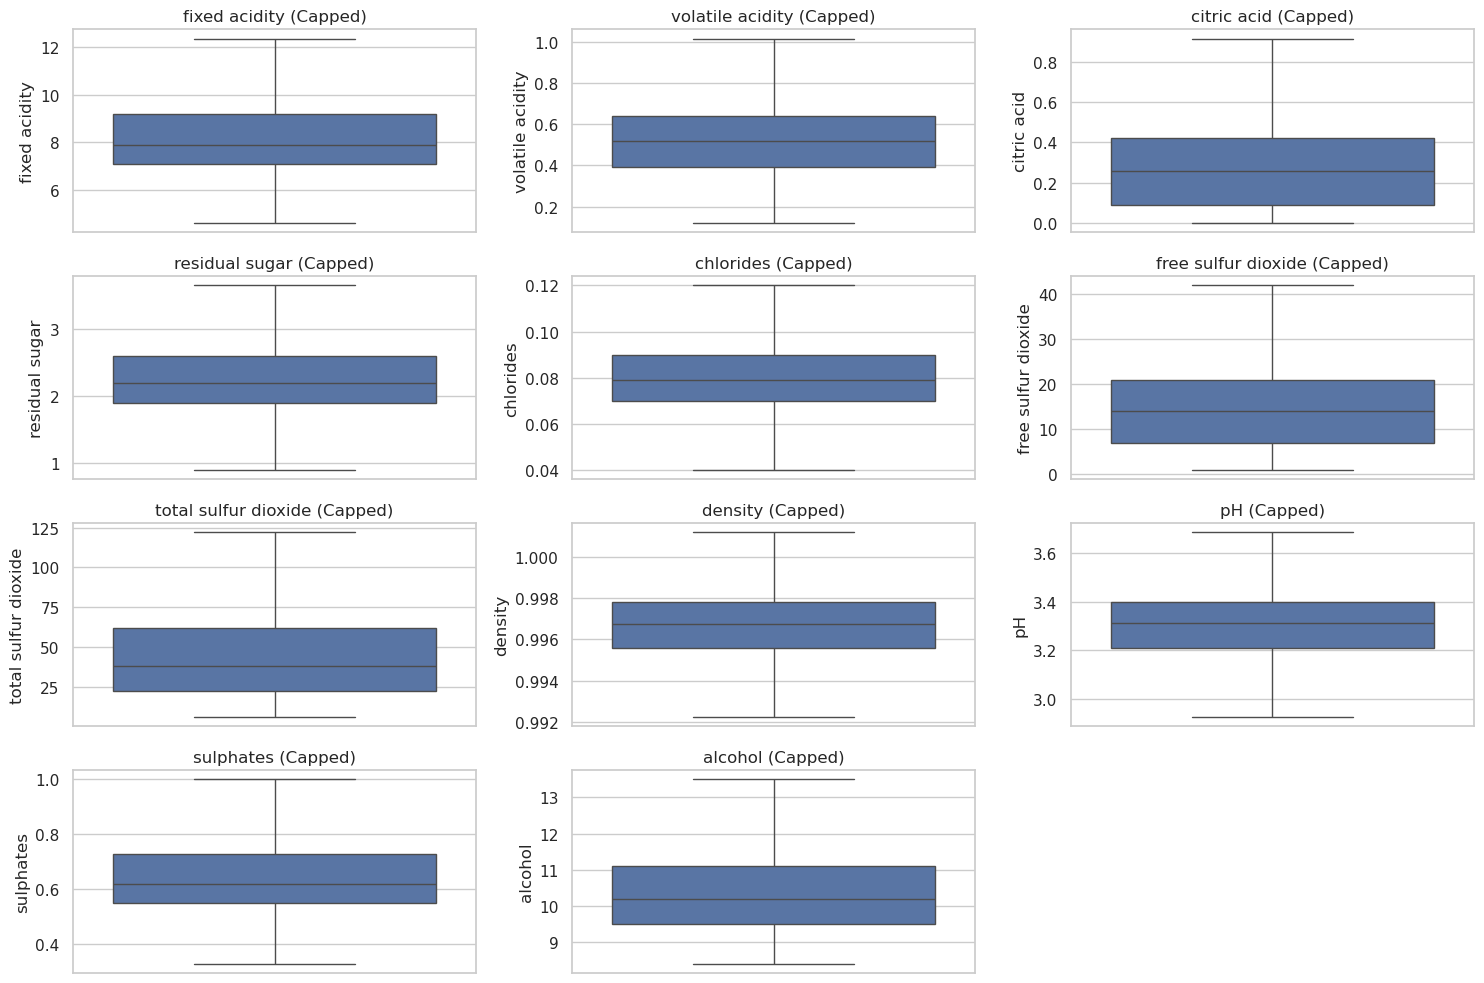

In [327]:
# Visualize cleaned data (correctly use wine_cleaned here)
plt.figure(figsize=(15, 10))
for i, col in enumerate(wine_cleaned.columns[:-1]):
    plt.subplot(4, 3, i + 1)
    sns.boxplot(y=wine_cleaned[col])
    plt.title(f"{col} (Capped)")
plt.tight_layout()
plt.show()

## <span style="color: orange;"> Data Visualization <span>

### Distribution of Wine Quality Ratings

Why Visualize Feature Distributions?
* Shape & Spread: Understand if features are normally distributed, skewed, or multi-modal.

* Detect anomalies: Identify unusual spikes or gaps in data.

* Guide preprocessing: Decide if transformations (e.g., log or Box-Cox) are needed before modeling.

* Feature scaling decisions: Helps decide whether scaling or normalization is required

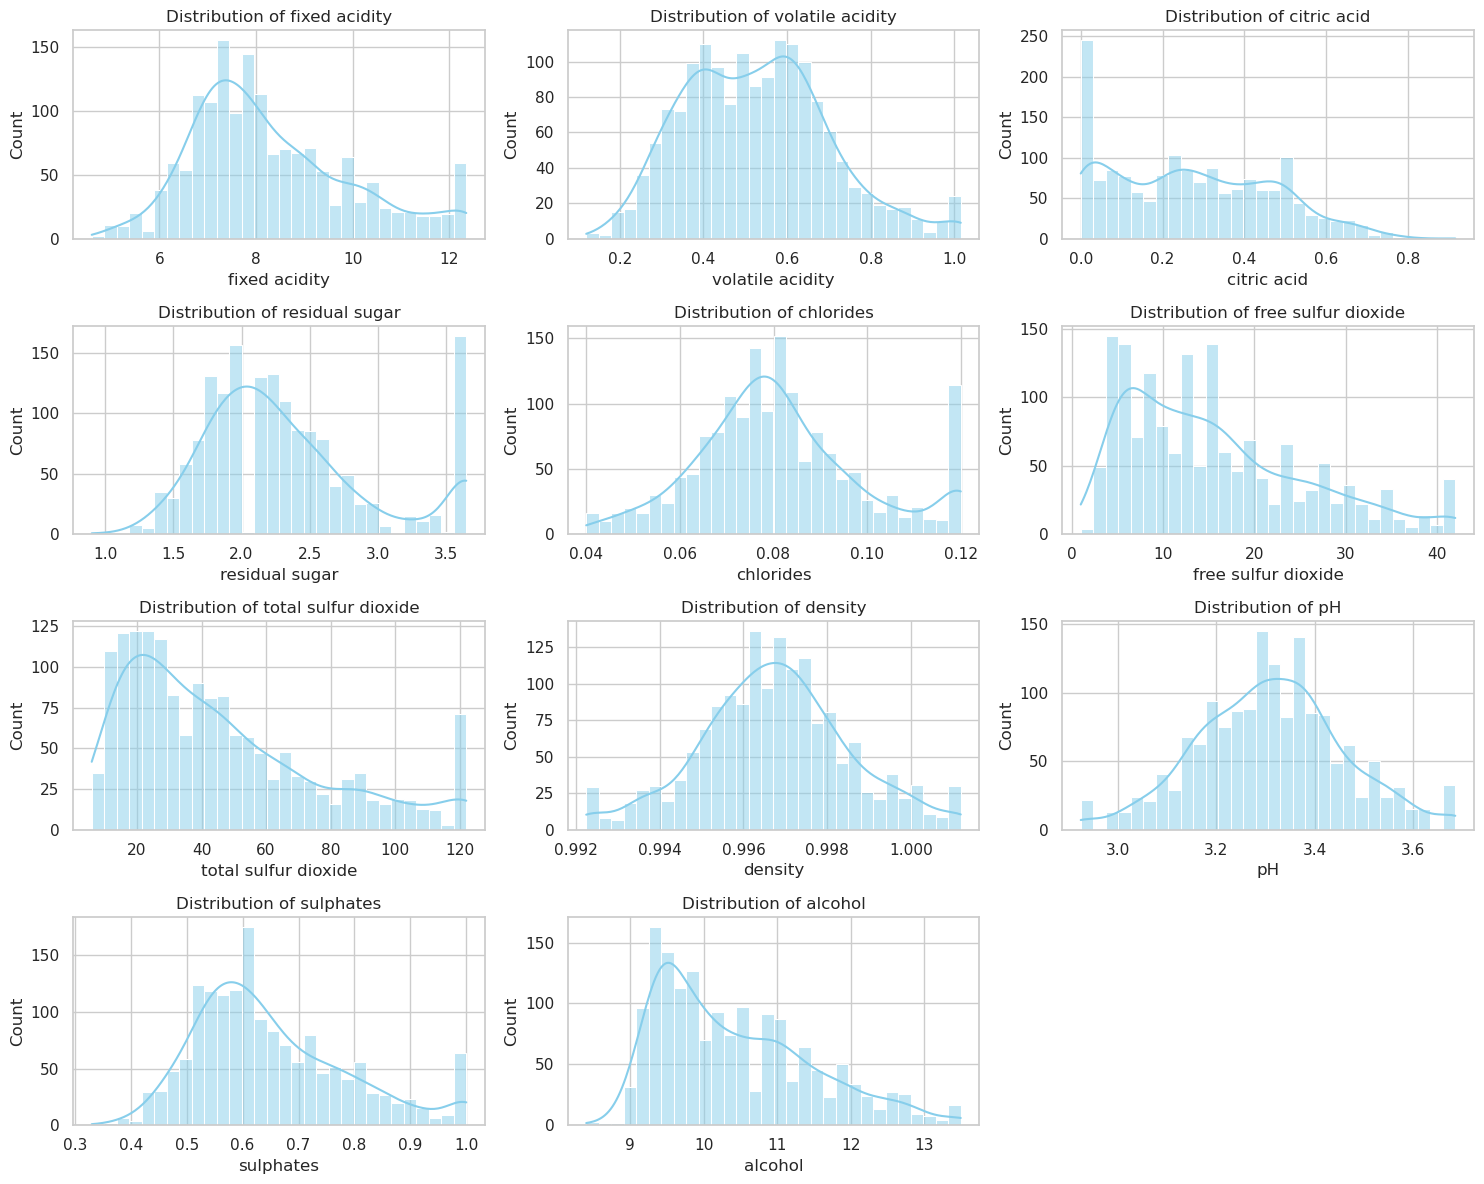

In [328]:
plt.figure(figsize=(15, 12))
for i, col in enumerate(wine_cleaned.columns[:-1]):  # Exclude 'quality'
    plt.subplot(4, 3, i + 1)
    sns.histplot(wine_cleaned[col], kde=True, bins=30, color='skyblue')
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()


## Correlation Matrix

The heatmap (sns.heatmap) shows:

* Positive correlations (red): Higher values in one feature correspond to higher values in another.

* Negative correlations (blue): Higher values in one feature correspond to lower values in another.

* Annotations: Correlation coefficients (e.g., 0.48 for alcohol and quality).

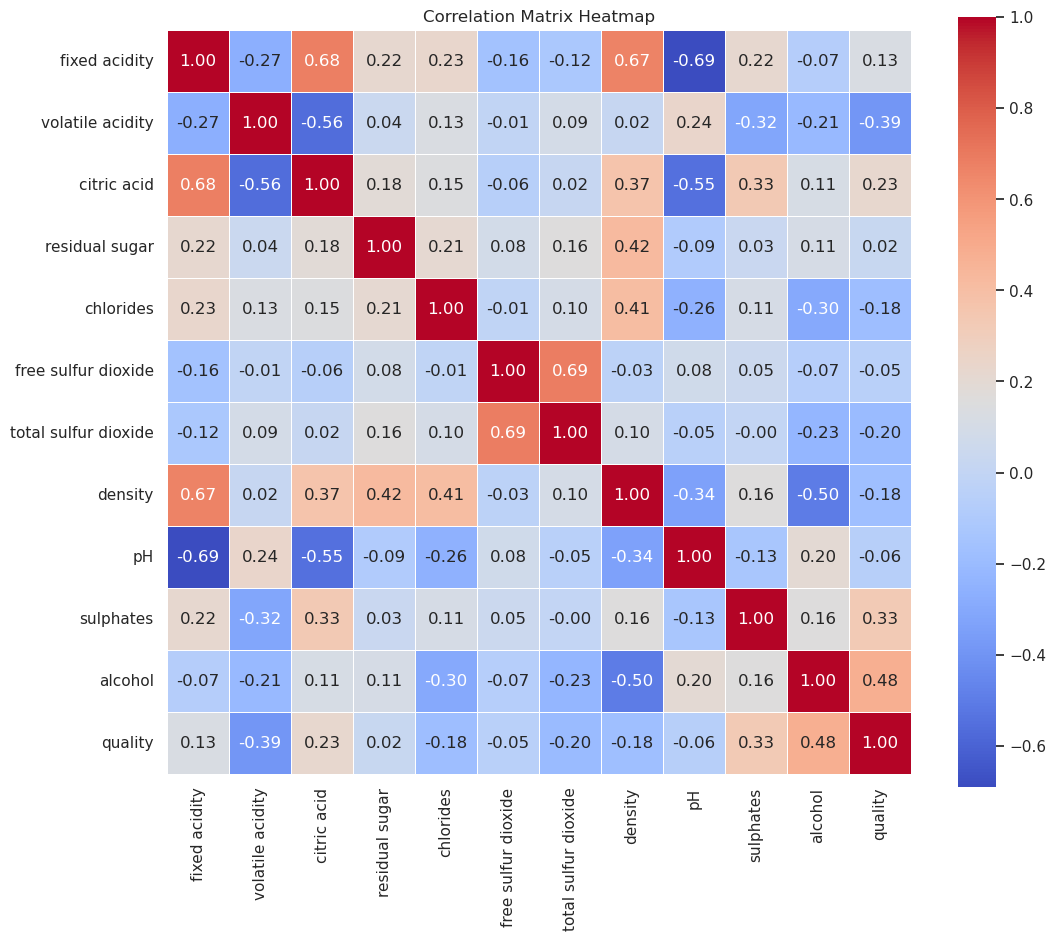

In [329]:
plt.figure(figsize=(12, 10))  # Set figure size

# Compute correlation matrix
corr = wine_cleaned.corr()

# Plot heatmap with annotations
sns.heatmap(
    corr,
    annot=True,          # Show correlation coefficients
    fmt=".2f",           # Format numbers to 2 decimal places
    cmap='coolwarm',     # Color palette (blue-red)
    square=True,         # Make cells square-shaped
    linewidths=0.5       # Lines between cells for clarity
)

plt.title("Correlation Matrix Heatmap")
plt.show()



Top Influencers on Wine Quality:

* Alcohol (+0.48): Higher alcohol content → better quality.

* Volatile Acidity (-0.39): Higher acetic acid → worse quality (vinegar-like taste).

* Sulphates (+0.33): Additives that may preserve freshness/positively impact quality.

Weak/Negligible Correlations:

residual sugar, free sulfur dioxide, and pH have minimal impact on quality.

In [330]:
correlation_with_quality = corr['quality'].sort_values(ascending=False)
print("Correlation with Quality:\n", correlation_with_quality)


Correlation with Quality:
 quality                 1.000000
alcohol                 0.478556
sulphates               0.328710
citric acid             0.227144
fixed acidity           0.125442
residual sugar          0.023790
free sulfur dioxide    -0.050641
pH                     -0.061507
density                -0.176330
chlorides              -0.183037
total sulfur dioxide   -0.201542
volatile acidity       -0.387608
Name: quality, dtype: float64


## Pair Plots of selected features

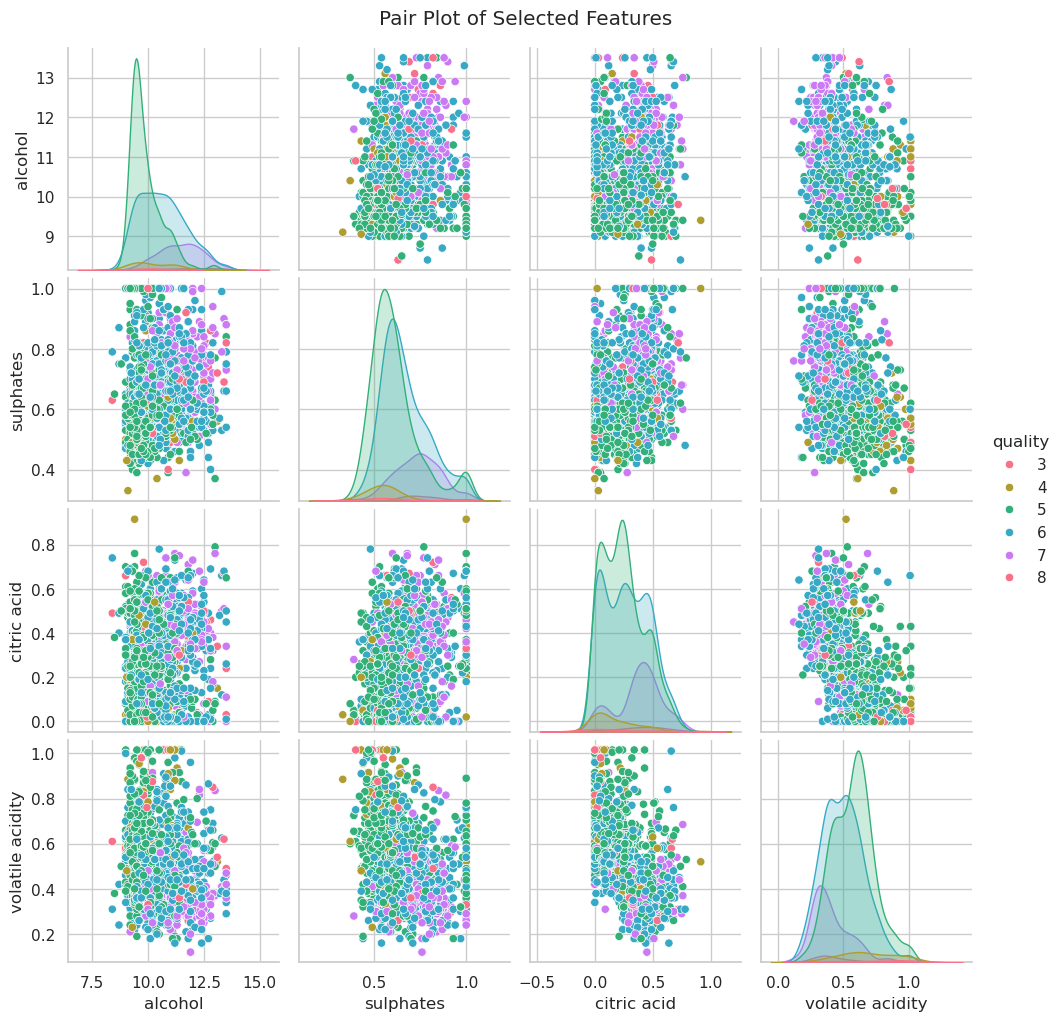

In [331]:
# Select a few key features to avoid overplotting
selected_cols = ['alcohol', 'sulphates', 'citric acid', 'volatile acidity', 'quality']
sns.pairplot(wine_cleaned[selected_cols], hue='quality', palette='husl')
plt.suptitle("Pair Plot of Selected Features", y=1.02)
plt.show()


# <span style="color: blue;"> K-Nearest Neighbors (KNN) algorithm <span>

## <span style="color: orange;"> Data Splitting <span>


X_train, X_test, y_train, y_test are created with an 80-20 split.
random_state=42 ensures reproducibility.


In [332]:
# 1. Split the data into features (X) and target (y)
X = wine_cleaned.drop('quality', axis=1)  # Features
y = wine_cleaned['quality']               # Target variable

# 2. Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## <span style="color: orange;"> Feature Scaling <span>


KNN relies on distances, so scaling (StandardScaler) is critical to ensure no feature dominates due to different units (e.g., alcohol vs. pH).


In [333]:

# 3. Feature Scaling (KNN is distance-based, so scaling is crucial!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## <span style="color: orange;">Model Training & Prediction <span>


Default KNeighborsClassifier with k=5 (5 nearest neighbors).

Predictions (y_pred) are made on the scaled test set.

In [334]:
# 4. Train the KNN model (default k=5)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# 5. Make predictions
y_pred = knn.predict(X_test_scaled)


## <span style="color: orange;"> Evaluation Metrics <span>


Accuracy: Percentage of correct predictions.

Classification Report: Precision, recall, F1-score per class.

Confusion Matrix: Shows correct vs. misclassified samples.


In [335]:

# 6. Evaluate the model
print("\nModel Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))





Model Evaluation:
Accuracy: 0.58125

Classification Report:
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.25      0.10      0.14        10
           5       0.62      0.70      0.66       130
           6       0.55      0.59      0.57       132
           7       0.62      0.38      0.47        42
           8       0.00      0.00      0.00         5

    accuracy                           0.58       320
   macro avg       0.34      0.30      0.31       320
weighted avg       0.57      0.58      0.57       320



/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


| Term          | Meaning                                                              |
| ------------- | -------------------------------------------------------------------- |
| **Precision** | % of predicted labels that were correct (e.g., precision of 5 = 62%) |
| **Recall**    | % of actual labels correctly identified (e.g., recall of 5 = 70%)    |
| **F1-score**  | Harmonic mean of precision & recall → balances both                  |
| **Support**   | Actual count of instances in the test set for each class             |


## <span style="color: orange;">Confusion Matrix (Counts) <span>

Shows how many samples were predicted as each class.

Diagonal elements = correct predictions.

Off-diagonal = misclassifications (e.g., class 5 predicted as 6, etc.).

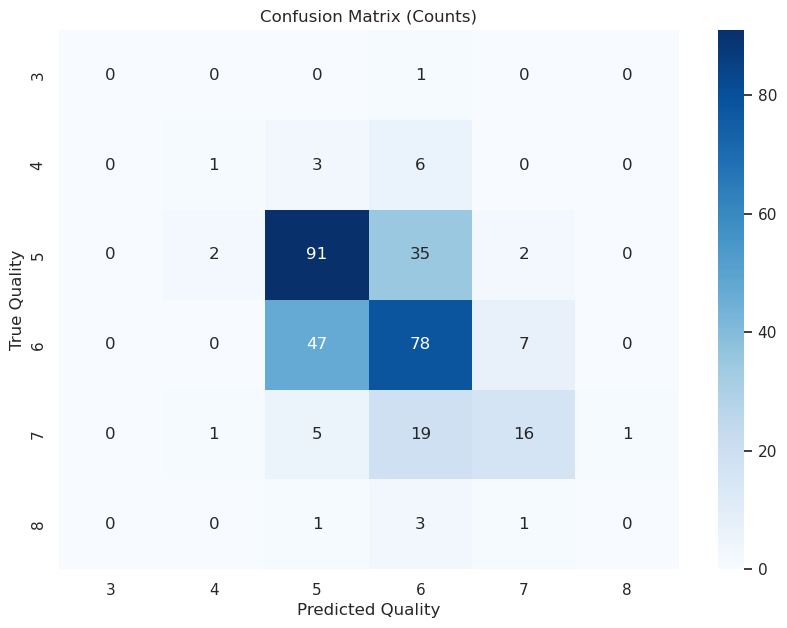

In [336]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting
plt.figure(figsize=(10, 7))
sns.heatmap(cm, 
            annot=True, 
            fmt='d',          # 'd' = integer formatting
            cmap='Blues', 
            xticklabels=sorted(y_test.unique()), 
            yticklabels=sorted(y_test.unique()))
plt.title('Confusion Matrix (Counts)')
plt.xlabel('Predicted Quality')
plt.ylabel('True Quality')
plt.show()


## <span style="color: orange;"> Confusion Matrix (Normalized) <span>


 Each row is normalized (percentages add up to 1) → easier to compare across classes with different sample sizes.

Shows percentage of correctly and incorrectly classified samples per actual class.

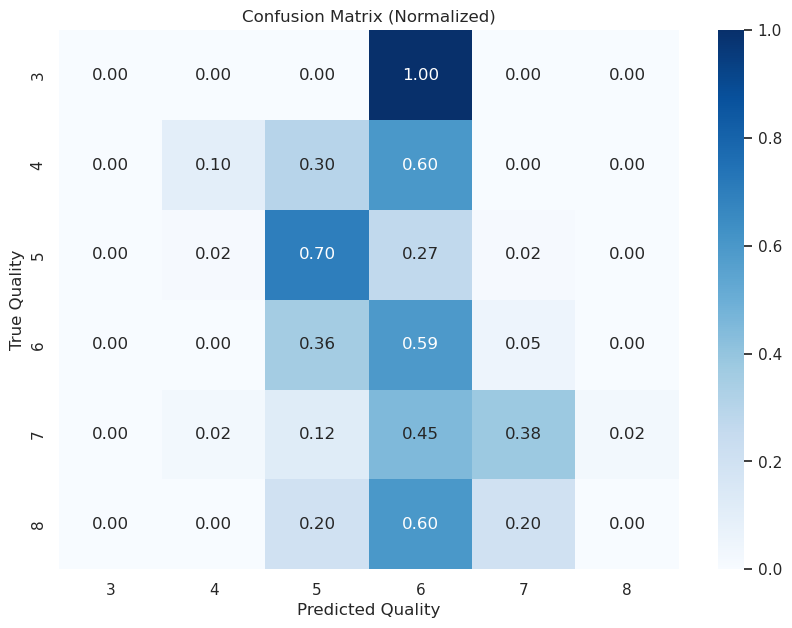

In [337]:
# Normalized Confusion Matrix (Percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row

plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, 
            annot=True, 
            fmt='.2f',       # 2 decimal places for percentages
            cmap='Blues', 
            xticklabels=sorted(y_test.unique()), 
            yticklabels=sorted(y_test.unique()))
plt.title('Confusion Matrix (Normalized)')
plt.xlabel('Predicted Quality')
plt.ylabel('True Quality')
plt.show()



## <span style="color: orange;"> Hyperparameter Tuning <span>


GridSearchCV tests k values from 1 to 30 to find the optimal number of neighbors (best_k).

Cross-validation (cv=5) ensures robustness.

In [338]:

# 7. Hyperparameter Tuning (Finding the best 'k')
param_grid = {'n_neighbors': range(1, 30)}  # Test k from 1 to 30
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)  # 5-fold cross-validation
grid_search.fit(X_train_scaled, y_train)

# Best parameters and model
best_k = grid_search.best_params_['n_neighbors']
best_knn = grid_search.best_estimator_

print("\nBest k:", best_k)

# Evaluate the tuned model
y_pred_tuned = best_knn.predict(X_test_scaled)
print("\nTuned Model Accuracy:", accuracy_score(y_test, y_pred_tuned))


Best k: 1

Tuned Model Accuracy: 0.61875


The model performed best on validation data when k = 1.

On the test set, it achieved ~61.9% accuracy, which is an improvement over the previous 58.1%.

## <span style="color: orange;"> Feature Selection <span>


Feature selection is a crucial step, especially for distance-based algorithms like K-Nearest Neighbors (KNN), 

which can be sensitive to irrelevant or noisy features. By selecting only the most informative features, here I

aim to:
*  Improve model accuracy
*  Reduce overfitting
*  Speed up training and prediction
*  Enhance interpretability of the model

 **ANOVA F-test:**
   - Used `SelectKBest` with `f_classif` to score features based on their statistical relationship with the target variable.
   - Higher F-scores indicate greater discriminatory power between classes.
   - Selected top 5 features with the highest F-scores to build a reduced model.

 **Mutual Information:**
   - Calculated MI scores using `mutual_info_classif` to measure the dependency between each feature and the target variable.
   - This provides a non-linear, information-theoretic perspective.

Feature Scores:
                 Feature  ANOVA_F_Score  Mutual_Info_Score
10               alcohol     117.631814           0.173302
1       volatile acidity      58.726701           0.141552
9              sulphates      39.904344           0.069409
6   total sulfur dioxide      29.058323           0.081340
2            citric acid      19.829511           0.044600
4              chlorides      13.812047           0.021499
7                density      13.575733           0.094326
0          fixed acidity       6.336301           0.039117
5    free sulfur dioxide       4.851819           0.031451
8                     pH       4.429766           0.031070
3         residual sugar       1.890118           0.006774


/tmp/ipykernel_1126/3172241337.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_scores, x='ANOVA_F_Score', y='Feature', palette='viridis')


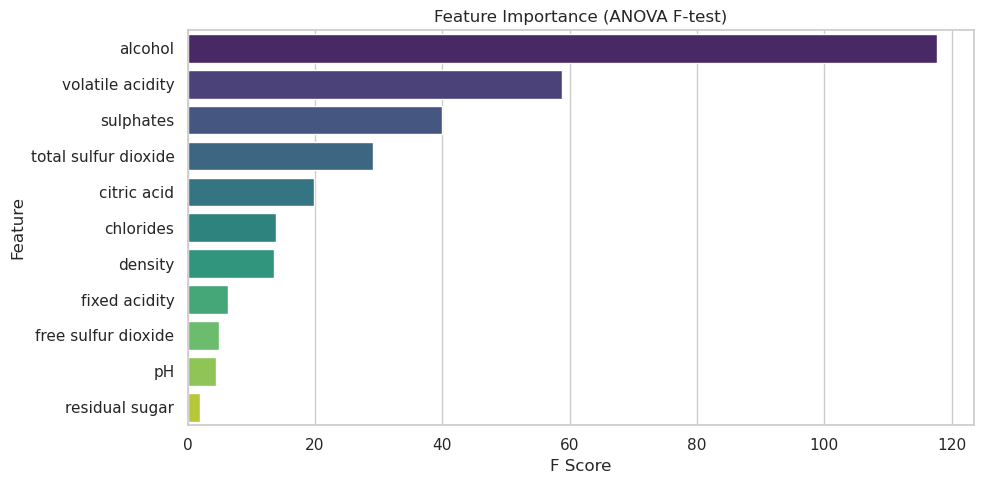

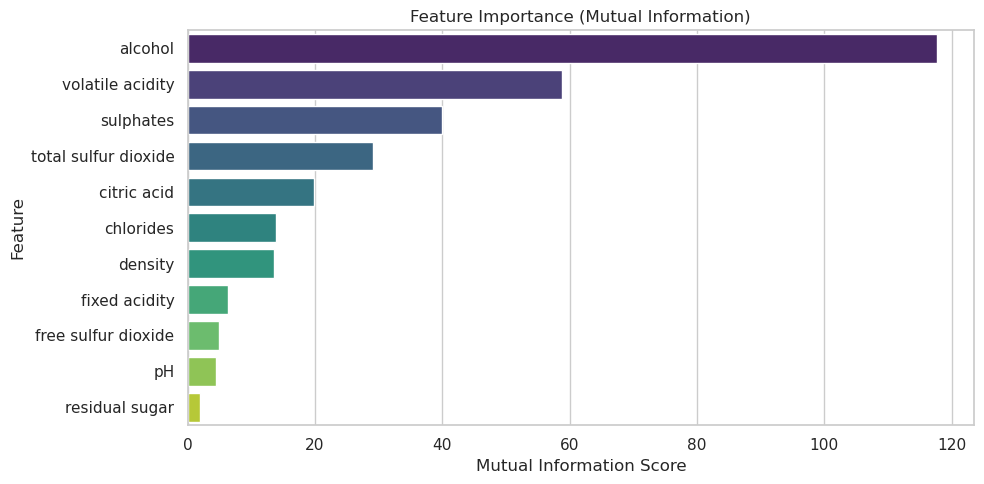

In [339]:

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler

# Applied StandardScaler to normalize the dataset since KNN relies on Euclidean distance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- ANOVA F-test Feature Selection ---
selector_f = SelectKBest(score_func=f_classif, k='all')
selector_f.fit(X_scaled, y)
f_scores = selector_f.scores_

# --- Mutual Information Feature Selection ---
selector_mi = SelectKBest(score_func=mutual_info_classif, k='all')
selector_mi.fit(X_scaled, y)
mi_scores = selector_mi.scores_

# --- Create DataFrame of Scores ---
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'ANOVA_F_Score': f_scores,
    'Mutual_Info_Score': mi_scores
}).sort_values(by='ANOVA_F_Score', ascending=False)

# --- Print Scores Table ---
print("Feature Scores:")
print(feature_scores)

# --- Plot 1: ANOVA F-test Scores ---
plt.figure(figsize=(10, 5))
sns.barplot(data=feature_scores, x='ANOVA_F_Score', y='Feature', palette='viridis')
plt.title('Feature Importance (ANOVA F-test)')
plt.xlabel('F Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# --- Plot 2: Mutual Information Scores ---
feature_scores_sorted_mi = feature_scores.sort_values(by='Mutual_Info_Score', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(data=feature_scores, x='ANOVA_F_Score', y='Feature', hue='Feature', palette='viridis', legend=False)

plt.title('Feature Importance (Mutual Information)')
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


Outputs a hybrid top-5 feature list that considers both linear and non-linear relationships with the target.

In [340]:
# Select top 5 features by ANOVA F-test
top_n = 5
top_features = feature_scores.sort_values(by='ANOVA_F_Score', ascending=False).head(top_n)['Feature'].tolist()

# Create reduced X using only top features
X_reduced = wine_cleaned[top_features]

# Train/test split on reduced data
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Scale
X_train_r_scaled = scaler.fit_transform(X_train_r)
X_test_r_scaled = scaler.transform(X_test_r)

# Train and evaluate
knn_reduced = KNeighborsClassifier(n_neighbors=best_k)  # use best_k from earlier
knn_reduced.fit(X_train_r_scaled, y_train_r)
y_pred_r = knn_reduced.predict(X_test_r_scaled)

print("\nReduced Model Accuracy (Top 5 Features):", accuracy_score(y_test_r, y_pred_r))
# Use all features with ANOVA score > 10
selected_features = feature_scores[feature_scores['ANOVA_F_Score'] > 10]['Feature'].tolist()
print("Selected features:", selected_features)
# Normalize both scores
feature_scores['F_norm'] = feature_scores['ANOVA_F_Score'] / feature_scores['ANOVA_F_Score'].max()
feature_scores['MI_norm'] = feature_scores['Mutual_Info_Score'] / feature_scores['Mutual_Info_Score'].max()
feature_scores['Combined_Score'] = feature_scores['F_norm'] + feature_scores['MI_norm']

# Sort by combined score
top_features_combined = feature_scores.sort_values(by='Combined_Score', ascending=False).head(5)['Feature'].tolist()
print("Top 5 features by combined score:", top_features_combined)



Reduced Model Accuracy (Top 5 Features): 0.628125
Selected features: ['alcohol', 'volatile acidity', 'sulphates', 'total sulfur dioxide', 'citric acid', 'chlorides', 'density']
Top 5 features by combined score: ['alcohol', 'volatile acidity', 'sulphates', 'total sulfur dioxide', 'density']


**Reduced Model:**
   - Trained a KNN model using only the top 5 features selected via ANOVA.
   - This reduced model achieved **higher accuracy** than using all features.

In [341]:
# 15. Permutation importance on reduced model
result = permutation_importance(knn_reduced, X_test_r_scaled, y_test_r, n_repeats=10, random_state=42, n_jobs=-1)
print("\nPermutation Importance of Top Features:")
for i in result.importances_mean.argsort()[::-1]:
    print(f"{top_features[i]}: {result.importances_mean[i]:.4f}")  # Use top_features that model was trained on


# 13. Save model package (model, scaler, features, etc.) in your folder
import os
save_dir = "../../models/FC211044_K-Nearest-Neighbors-(KNN)-models"
os.makedirs(save_dir, exist_ok=True)

# Assuming scaler_r is your fitted scaler from training, do NOT overwrite it before saving!

model_package = {
    'model': knn_reduced,
    'scaler': scaler,
    'feature_names': top_features,  # Matches features used for training
    'model_name': 'KNeighborsClassifier',
    'best_k': best_k,
    'accuracy': accuracy_score(y_test_r, y_pred_r),
    'classes': knn_reduced.classes_,
    'training_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'model_parameters': knn_reduced.get_params()
}

model_filename = os.path.join(save_dir, f"wine_quality_knn_top_features_{best_k}.joblib")
joblib.dump(model_package, model_filename)

# Save using pickle as well
pkl_filename = os.path.join(save_dir, f"wine_quality_knn_top_features_{best_k}.pkl")
with open(pkl_filename, 'wb') as f:
    pickle.dump(model_package, f)
print(f" Model also saved as: {pkl_filename} (pickle format)")

print(f"\n Model saved to {model_filename}")

# 14. Example of loading and predicting using saved model
loaded_package = joblib.load(model_filename)
loaded_model = loaded_package['model']
loaded_scaler = loaded_package['scaler']
loaded_features = loaded_package['feature_names']

# Sample input with correct feature order (example values)
sample_input = pd.DataFrame([[7.4, 0.70, 0.00, 0.076, 11.0]], columns=loaded_features)
sample_input_scaled = loaded_scaler.transform(sample_input)


# Predict
sample_prediction = loaded_model.predict(sample_input_scaled)
print(f"\n🔮 Predicted wine quality class for sample input: {sample_prediction[0]}")


Permutation Importance of Top Features:
alcohol: 0.1591
volatile acidity: 0.1581
sulphates: 0.1272
citric acid: 0.1069
total sulfur dioxide: 0.1034
 Model also saved as: ../../models/FC211044_K-Nearest-Neighbors-(KNN)-models/wine_quality_knn_top_features_1.pkl (pickle format)

 Model saved to ../../models/FC211044_K-Nearest-Neighbors-(KNN)-models/wine_quality_knn_top_features_1.joblib

🔮 Predicted wine quality class for sample input: 4
